## 필요 라이브러리 설치

In [28]:
!pip install timm
!pip install grad-cam
!pip uninstall -y grad-cam
!pip install git+https://github.com/jacobgil/pytorch-grad-cam.git

Found existing installation: grad-cam 1.5.5
Uninstalling grad-cam-1.5.5:
  Successfully uninstalled grad-cam-1.5.5
  Cloning https://github.com/jacobgil/pytorch-grad-cam.git to /tmp/pip-req-build-ju39_diz
  Running command git clone --filter=blob:none --quiet https://github.com/jacobgil/pytorch-grad-cam.git /tmp/pip-req-build-ju39_diz
  Resolved https://github.com/jacobgil/pytorch-grad-cam.git to commit 781dbc0d16ffa95b6d18b96b7b829840a82d93d1
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Created wheel for grad-cam: filename=grad_cam-1.5.5-py3-none-any.whl size=43670 sha256=de8fad0d545e6f3b2cfc9f6a1276a4f7de7ab430e0d94d77fa50a32dd6f94b07
  Stored in directory: /tmp/pip-ephem-wheel-cache-1sufv1zk/wheels/a0/4d/c8/0502c44e32030c99ffab1b98075308a1ef9829c1835537afc6
Successfully built grad-cam


### 라이브러리 불러오기

In [2]:
import os
import torch
import torch.nn as nn
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
import timm
from sklearn.metrics import accuracy_score, f1_score
import matplotlib.pyplot as plt

### Google Drive 연동

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


### 경로 설정

In [4]:
DATA_DIR = "/content/drive/MyDrive/augmented_dataset"

### 데이터셋 로딩(ToTensor)

In [5]:
transform = transforms.ToTensor()

train_dataset = datasets.ImageFolder(os.path.join(DATA_DIR, "train"), transform=transform)
test_dataset  = datasets.ImageFolder(os.path.join(DATA_DIR, "test"), transform=transform)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader  = DataLoader(test_dataset, batch_size=32, shuffle=False)

print("클래스 인덱스 매핑:", train_dataset.class_to_idx)

클래스 인덱스 매핑: {'fake': 0, 'real': 1}


### vision Transformer 모델 정의

In [6]:

class ViTBinaryClassifier(nn.Module):
    def __init__(self):
        super(ViTBinaryClassifier, self).__init__()
        self.model = timm.create_model('vit_base_patch16_224', pretrained=True)
        self.model.head = nn.Linear(self.model.head.in_features, 1)  # 이진 분류

    def forward(self, x):
        return self.model(x)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = ViTBinaryClassifier().to(device)

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


model.safetensors:   0%|          | 0.00/346M [00:00<?, ?B/s]

### 학습 설정

In [7]:
criterion = nn.BCEWithLogitsLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)

### 학습 및 평가

In [8]:
num_epochs = 50
patience = 5
patience_counter = 0
best_f1 = 0
best_epoch = 0

train_losses = []
val_f1_scores = []
best_model_path = "/content/best_vit_model.pth"

for epoch in range(num_epochs):
    model.train()
    total_loss = 0.0
    for images, labels in train_loader:
        images = images.to(device)
        labels = labels.float().unsqueeze(1).to(device)

        outputs = model(images)
        loss = criterion(outputs, labels)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        total_loss += loss.item()

    avg_loss = total_loss / len(train_loader)
    train_losses.append(avg_loss)

    # Validation F1 측정
    model.eval()
    preds, true_labels = [], []
    with torch.no_grad():
        for images, labels in test_loader:
            images = images.to(device)
            outputs = model(images)
            predictions = torch.sigmoid(outputs).cpu().numpy() > 0.5
            preds.extend(predictions.flatten())
            true_labels.extend(labels.numpy())

    f1 = f1_score(true_labels, preds)
    val_f1_scores.append(f1)

    print(f"[Epoch {epoch+1}] Loss: {avg_loss:.4f}, F1: {f1:.4f}")

    # Best F1 갱신 시 모델 저장
    if f1 > best_f1:
        best_f1 = f1
        best_epoch = epoch
        torch.save(model.state_dict(), best_model_path)
        print(f"📌 Best Model Saved (Epoch {epoch+1}, F1: {f1:.4f})")
        patience_counter = 0
    else:
        patience_counter += 1
        print(f"⏳ No improvement. Patience: {patience_counter}/{patience}")
        if patience_counter >= patience:
            print("Early stopping triggered.")
            break

print(f"Training complete. Best Epoch: {best_epoch+1}, Best F1: {best_f1:.4f}")

[Epoch 1] Loss: 0.5884, F1: 0.7775
📌 Best Model Saved (Epoch 1, F1: 0.7775)
[Epoch 2] Loss: 0.3791, F1: 0.8389
📌 Best Model Saved (Epoch 2, F1: 0.8389)
[Epoch 3] Loss: 0.2242, F1: 0.8324
⏳ No improvement. Patience: 1/5
[Epoch 4] Loss: 0.1349, F1: 0.8219
⏳ No improvement. Patience: 2/5
[Epoch 5] Loss: 0.0927, F1: 0.8186
⏳ No improvement. Patience: 3/5
[Epoch 6] Loss: 0.0738, F1: 0.7500
⏳ No improvement. Patience: 4/5
[Epoch 7] Loss: 0.0586, F1: 0.7794
⏳ No improvement. Patience: 5/5
Early stopping triggered.
Training complete. Best Epoch: 2, Best F1: 0.8389


### 학습 결과 시각화

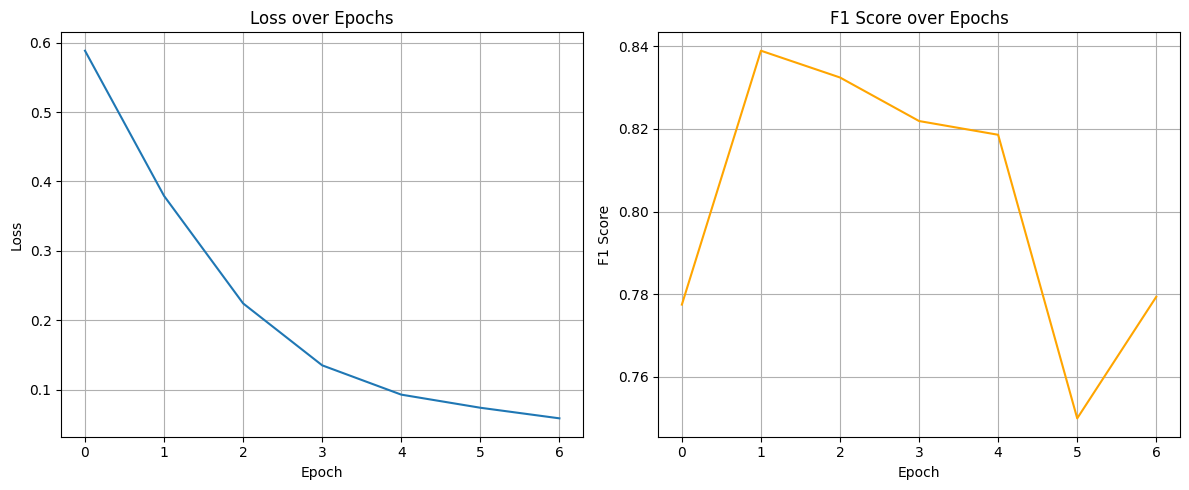

In [9]:
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(train_losses, label="Train Loss")
plt.title("Loss over Epochs")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.grid(True)

plt.subplot(1, 2, 2)
plt.plot(val_f1_scores, label="F1 Score", color='orange')
plt.title("F1 Score over Epochs")
plt.xlabel("Epoch")
plt.ylabel("F1 Score")
plt.grid(True)

plt.tight_layout()
plt.show()

### 저장된 모델 불러오기

In [10]:
model.load_state_dict(torch.load(best_model_path))
model.eval()

ViTBinaryClassifier(
  (model): VisionTransformer(
    (patch_embed): PatchEmbed(
      (proj): Conv2d(3, 768, kernel_size=(16, 16), stride=(16, 16))
      (norm): Identity()
    )
    (pos_drop): Dropout(p=0.0, inplace=False)
    (patch_drop): Identity()
    (norm_pre): Identity()
    (blocks): Sequential(
      (0): Block(
        (norm1): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
        (attn): Attention(
          (qkv): Linear(in_features=768, out_features=2304, bias=True)
          (q_norm): Identity()
          (k_norm): Identity()
          (attn_drop): Dropout(p=0.0, inplace=False)
          (proj): Linear(in_features=768, out_features=768, bias=True)
          (proj_drop): Dropout(p=0.0, inplace=False)
        )
        (ls1): Identity()
        (drop_path1): Identity()
        (norm2): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
        (mlp): Mlp(
          (fc1): Linear(in_features=768, out_features=3072, bias=True)
          (act): GELU(approximate=

## 최종평가

In [11]:
all_preds, all_labels = [], []
with torch.no_grad():
    for images, labels in test_loader:
        images = images.to(device)
        outputs = model(images)
        preds = torch.sigmoid(outputs).cpu().numpy() > 0.5
        all_preds.extend(preds.flatten())
        all_labels.extend(labels.numpy())

acc = accuracy_score(all_labels, all_preds)
f1 = f1_score(all_labels, all_preds)

print(f"\n Best 모델 기준 최종 Accuracy: {acc:.4f}, F1: {f1:.4f}")


 Best 모델 기준 최종 Accuracy: 0.8360, F1: 0.8389


### Confusion Matrix

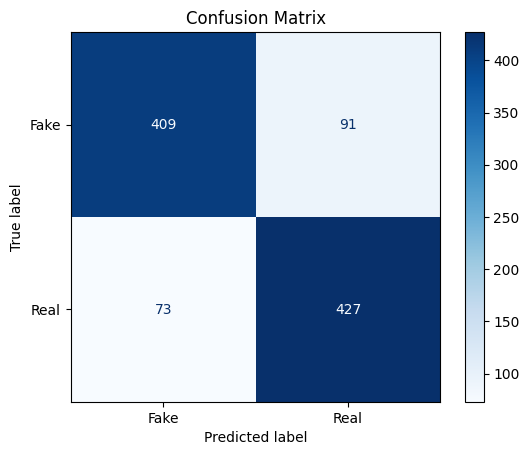

In [12]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
cm = confusion_matrix(all_labels, all_preds)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["Fake", "Real"])
disp.plot(cmap=plt.cm.Blues)
plt.title("Confusion Matrix")
plt.show()

### Accuracy, Recall, F1, Sensitivity, Specificity

In [13]:
from sklearn.metrics import recall_score
tn, fp, fn, tp = cm.ravel()
specificity = tn / (tn + fp)
recall = recall_score(all_labels, all_preds)

print(f"Accuracy: {acc:.4f}")
print(f"Recall (Sensitivity): {recall:.4f}")
print(f"F1 Score: {f1:.4f}")
print(f"Specificity: {specificity:.4f}")

Accuracy: 0.8360
Recall (Sensitivity): 0.8540
F1 Score: 0.8389
Specificity: 0.8180


### ROC Curve

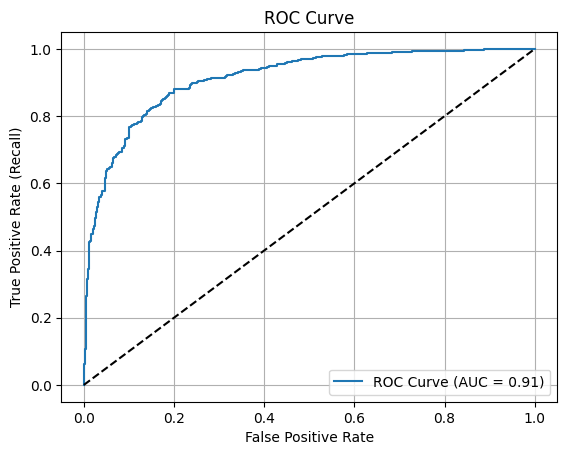

In [14]:
from sklearn.metrics import roc_curve, auc
model.eval()
all_probs = []
with torch.no_grad():
    for images, labels in test_loader:
        images = images.to(device)
        outputs = model(images)
        probs = torch.sigmoid(outputs).cpu().numpy()
        all_probs.extend(probs.flatten())

fpr, tpr, thresholds = roc_curve(all_labels, all_probs)
roc_auc = auc(fpr, tpr)

plt.figure()
plt.plot(fpr, tpr, label=f"ROC Curve (AUC = {roc_auc:.2f})")
plt.plot([0, 1], [0, 1], "k--")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate (Recall)")
plt.title("ROC Curve")
plt.legend(loc="lower right")
plt.grid(True)
plt.show()

### Parameter Count

In [15]:
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)
print(" Trainable Parameters:", count_parameters(model))

📌 Trainable Parameters: 85799425


### Inference Time

In [16]:
import time
dummy_input = torch.randn(1, 3, 224, 224).to(device)
start = time.time()
with torch.no_grad():
    _ = model(dummy_input)
end = time.time()
print(f" Inference Time (1 image): {end - start:.6f} seconds")

🕒 Inference Time (1 image): 0.010107 seconds


## Grad-CAM

In [1]:
from pytorch_grad_cam.utils.model_targets import BinaryClassifierOutputTarget
from pytorch_grad_cam import GradCAM
from pytorch_grad_cam.utils.image import show_cam_on_image

from torchvision import transforms
import matplotlib.pyplot as plt
import numpy as np

target_layer = model.model.blocks[-1].norm1  # ViT의 마지막 attention 블록

inv_normalize = transforms.Normalize(
    mean=[0., 0., 0.],
    std=[1., 1., 1.]
)

def show_gradcam_examples():
    fake_imgs, real_imgs = [], []

    for images, labels in test_loader:
        for img, label in zip(images, labels):
            if label.item() == 0 and len(fake_imgs) < 2:
                fake_imgs.append(img)
            elif label.item() == 1 and len(real_imgs) < 2:
                real_imgs.append(img)
            if len(fake_imgs) == 2 and len(real_imgs) == 2:
                break
        if len(fake_imgs) == 2 and len(real_imgs) == 2:
            break

    all_imgs = fake_imgs + real_imgs
    all_labels = [0, 0, 1, 1]
    all_titles = ["Fake1", "Fake2", "Real1", "Real2"]

    plt.figure(figsize=(12, 8))

    # ✅ GradCAM에서 device 인자 사용
    cam = GradCAM(model=model, target_layers=[target_layer], device=device)

    for idx, (img, label, title) in enumerate(zip(all_imgs, all_labels, all_titles)):
        input_tensor = img.unsqueeze(0).to(device)
        targets = [BinaryClassifierOutputTarget(label)]

        grayscale_cam = cam(input_tensor=input_tensor, targets=targets)[0]

        img_np = inv_normalize(img).permute(1, 2, 0).cpu().numpy()
        img_np = np.clip(img_np, 0, 1)
        cam_image = show_cam_on_image(img_np, grayscale_cam, use_rgb=True)

        # CAM Overlay
        plt.subplot(2, 4, idx * 2 + 1)
        plt.imshow(cam_image)
        plt.title(title)
        plt.axis('off')

        # Heatmap
        plt.subplot(2, 4, idx * 2 + 2)
        plt.imshow(grayscale_cam, cmap='jet')
        plt.title(f"{title} CAM")
        plt.axis('off')

    plt.tight_layout()
    plt.show()

# 실행
show_gradcam_examples()

NameError: name 'model' is not defined